In [116]:
# import libraries
from operator import itemgetter

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd

## Part 1: London’s Underground Resilience

### I.1.1 Centrality Measures

#### Betweeness Centrality
- Betweeness Centrality measures the extent to which a node lies on the shortest path between other nodes in the network.
- Contextual Defintion: It identifies stations through which the highest number of shortest paths pass through. BC identifies the stations needed to transfer passengers *efficiently* throughout the network
- Why it's important: Identifies stations that , if closed, would cause the greatest increase in journey times across the network
\begin{equation} C_{B}(v) = \sum_{s,t \neq v} \frac{\sigma_{st}(v)}{\sigma_{st}} \end{equation}

#### Degree Centrality
- Definition: Degree Centrality measures the number of *one-edge* direct connections a node has.
- Contextual Defintion: This highlights the stations with the most direct connections to other stations, indicating hubs or key transfer points.
- Why it's important: Identifies the most interconnected stations. These nodes facilitate multiple route options.

\begin{equation} C_{D}(v) = \frac{deg(v)}{n-1} \end{equation}

#### Closeness Centrality
- Closeness Centrality is a score that indicates how close a node is to all other nodes in the network, based on the shortest paths.
- Contextual Defintion: Point to stations that are most efficiently located to reach all other stations in the network, minimising travel time for commuters
- Why it's important: Identifies stations that offer the shortest average journey time to all other stations.

\begin{equation} C_{i}= \frac{1}{l_{i}} = \frac{n}{\sum_{j} d_{ij}}\end{equation}

### I.1.2 Construct Network

In [102]:
# read in london.graph
G = nx.read_graphml("data/london.graph.xml")

# print node / edge count
print(G)

# get 'node' attributes
list(G.nodes(data=True))[0]

Graph with 401 nodes and 467 edges


('Uxbridge', {'coords': '(505605.79164161877, 184156.71191985375)'})

In [103]:
# convert coords: list to tuple
for n in G.nodes():
    G.nodes[n]["coords"] = eval(G.nodes[n]["coords"])

# check
list(G.nodes(data=True))[0]

('Uxbridge', {'coords': (505605.79164161877, 184156.71191985375)})

In [104]:
# get edge attributes
list(G.edges(data=True))[0]

('Uxbridge',
 'Hillingdon',
 {'length': 2144.402930417613, 'line_name': 'Piccadilly', 'flows': 7080})

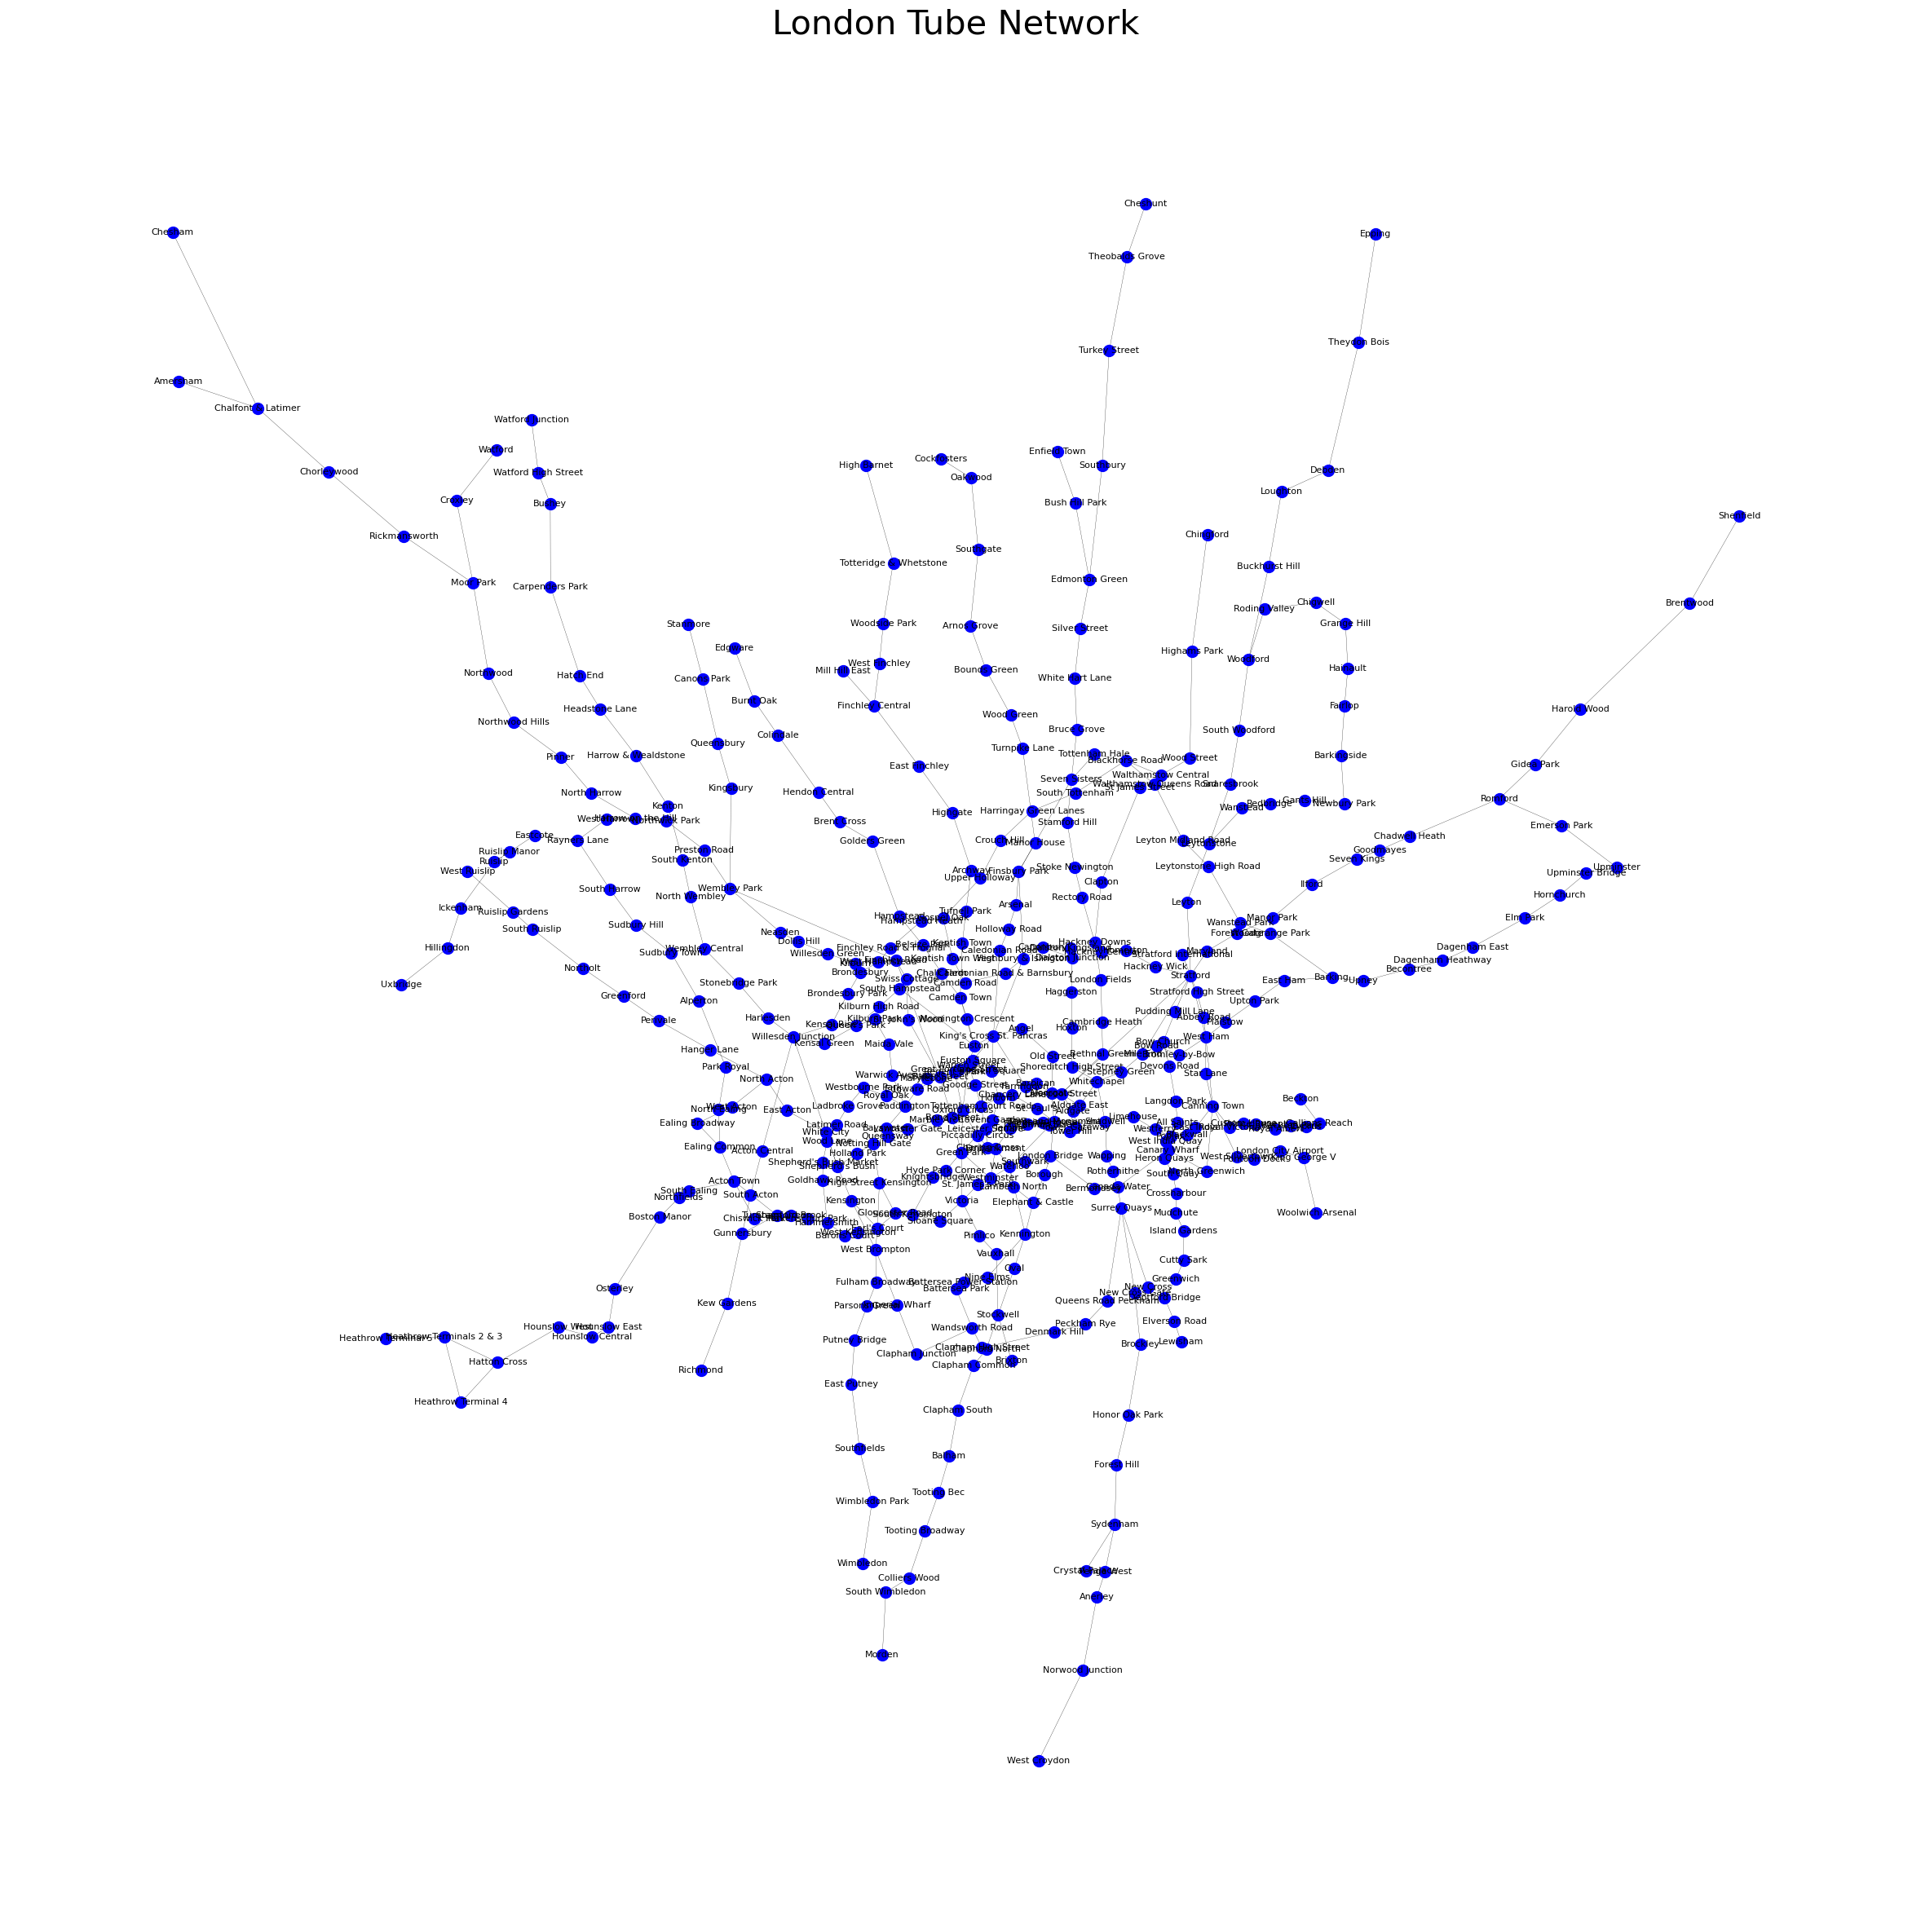

In [105]:
# edges look good
# plot tube graph
fig, ax = plt.subplots(figsize=(30, 30))
pos = nx.get_node_attributes(G, "coords")
nx.draw_networkx_nodes(G, pos, node_size=100, node_color="b")
nx.draw_networkx_edges(G, pos, arrows=False, width=0.2)

# station names
nx.draw_networkx_labels(G, pos, font_size=8, font_color="black")

# aesthetics
plt.title("London Tube Network", fontsize=30)
plt.axis("off")
plt.show()

In [106]:
# get edge list
df = nx.to_pandas_edgelist(G)
# did it work?
df.head()

,source,target,flows,length,line_name
0,Uxbridge,Hillingdon,7080,2144.402930,Piccadilly
1,Hillingdon,Ickenham,8453,1124.430585,Piccadilly
2,Ickenham,Ruislip,8984,1785.657867,Piccadilly
3,Ruislip,Ruislip Manor,9700,678.881293,Piccadilly
4,Ruislip Manor,Eastcote,10497,1126.217722,Piccadilly


### I.1.3 Centrality Calculations

#### Closeness Centrality

In [114]:
# calculate closeness
closeness_G = nx.closeness_centrality(G)

# add 'closeness' attribute to G
list(G.nodes(data=True))[0:5]

# check
list(G.nodes(data=True))[0:5]

[('Uxbridge',
  {'coords': (505605.79164161877, 184156.71191985375),
   'degree': 0.0025,
   'betw_t': 0.0}),
 ('Hillingdon',
  {'coords': (507544.8588852762, 185008.64550515497),
   'degree': 0.005,
   'betw_t': 399.0}),
 ('Ickenham',
  {'coords': (508089.8084796285, 185937.75443791348),
   'degree': 0.005,
   'betw_t': 796.0}),
 ('Ruislip',
  {'coords': (509483.21437480004, 187013.5122156188),
   'degree': 0.005,
   'betw_t': 1191.0}),
 ('Ruislip Manor',
  {'coords': (510118.8736871729, 187242.51348855108),
   'degree': 0.005,
   'betw_t': 1584.0})]

#### Degree Centrality

In [113]:
# calculate degree
degree_G = nx.degree_centrality(G)

# add 'degree' attribute to G
nx.set_node_attributes(G, dict(degree_G), "degree")

# check
list(G.nodes(data=True))[0:5]

[('Uxbridge',
  {'coords': (505605.79164161877, 184156.71191985375),
   'degree': 0.0025,
   'betw_t': 0.0}),
 ('Hillingdon',
  {'coords': (507544.8588852762, 185008.64550515497),
   'degree': 0.005,
   'betw_t': 399.0}),
 ('Ickenham',
  {'coords': (508089.8084796285, 185937.75443791348),
   'degree': 0.005,
   'betw_t': 796.0}),
 ('Ruislip',
  {'coords': (509483.21437480004, 187013.5122156188),
   'degree': 0.005,
   'betw_t': 1191.0}),
 ('Ruislip Manor',
  {'coords': (510118.8736871729, 187242.51348855108),
   'degree': 0.005,
   'betw_t': 1584.0})]

In [109]:
# convert to df
df_degree = pd.DataFrame(index=G.nodes())
df_degree["Degree_Centrality"] = pd.Series(nx.get_node_attributes(G, "degree"))

# print top 10 
df_sorted = df_degree.sort_values(["Degree_Centrality"], ascending=False)
df_sorted[0:10]

,Degree_Centrality
Stratford,0.0225
Bank and Monument,0.0200
Baker Street,0.0175
King's Cross St. Pancras,0.0175
Green Park,0.0150
Canning Town,0.0150
Earl's Court,0.0150
West Ham,0.0150
Waterloo,0.0150
Oxford Circus,0.0150


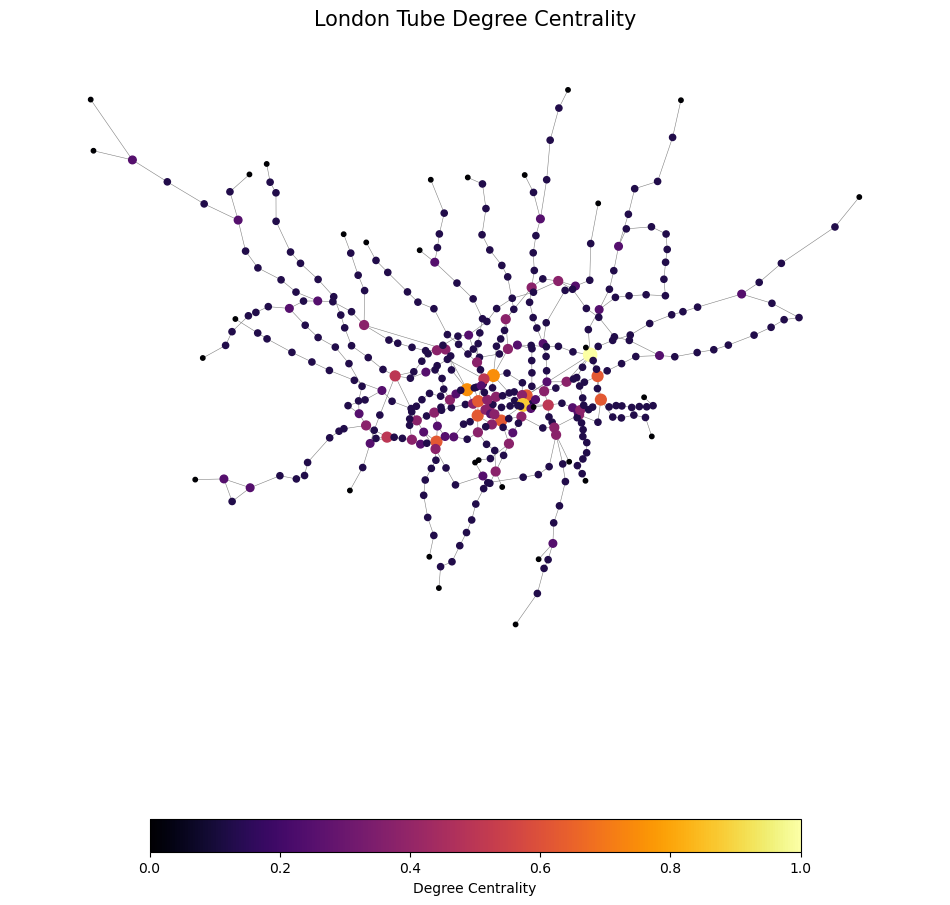

In [121]:
degrees = dict(G.degree())

# for loop to scale values
deg_size = [v * 10 for v in degrees.values()]

centrality = nx.degree_centrality(G)

# normalise values
min_cent = min(centrality.values())
max_cent = max(centrality.values())
norm_cent = [(value - min_cent) / (max_cent - min_cent) for value in centrality.values()]

# embed colour mapping 'inferno'
colors = plt.cm.inferno(norm_cent)

# plot !
fig, ax = plt.subplots(figsize=(12, 12))
nx.draw_networkx_edges(G, pos, edge_color="gray", width=0.4)
nod = nx.draw_networkx_nodes(G, pos=pos, node_color=colors, node_size=deg_size)

plt.colorbar(plt.cm.ScalarMappable(cmap="inferno"), ax=ax, orientation="horizontal", label="Degree Centrality", shrink=0.7)
plt.axis("off")
plt.title("London Tube Degree Centrality", fontsize=15)
plt.show()

#### Topological Betweeness Centrality

In [110]:
# calculate topological betweeness
G_topbetw = nx.betweenness_centrality(G, normalized=False)

# add 'topological betweenness' as 'betw_t'
nx.set_node_attributes(G, dict(G_topbetw), "betw_t")

# confirm 'betw_t' is added
list(G.nodes(data=True))[0:2]

[('Uxbridge',
  {'coords': (505605.79164161877, 184156.71191985375),
   'degree': 0.0025,
   'betw_t': 0.0}),
 ('Hillingdon',
  {'coords': (507544.8588852762, 185008.64550515497),
   'degree': 0.005,
   'betw_t': 399.0})]

In [111]:
# convert to df
df_betweeness_t = pd.DataFrame(index=G.nodes())
df_betweeness_t["Topological_Betweeness_Centrality"] = pd.Series(
    nx.get_node_attributes(G, "betw_t")
)

# print top 10 
df_sorted = df_betweeness_t.sort_values(
    ["Topological_Betweeness_Centrality"], ascending=False
)
df_sorted[0:10]

,Topological_Betweeness_Centrality
Stratford,23768.093434
Bank and Monument,23181.058947
Liverpool Street,21610.387049
King's Cross St. Pancras,20373.521465
Waterloo,19464.882323
Green Park,17223.622114
Euston,16624.275469
Westminster,16226.155916
Baker Street,15287.107612
Finchley Road,13173.758009


#### Betweeness Centrality

In [112]:
# calculate betweeness
bet_G=nx.betweenness_centrality(G, weight='weight', normalized=False)

pd.DataFrame.from_dict(bet_G,columns=['betweenness'],orient='index')[0:10]

,betweenness
Uxbridge,0.000000
Hillingdon,399.000000
Ickenham,796.000000
Ruislip,1191.000000
Ruislip Manor,1584.000000
Eastcote,1975.000000
Rayners Lane,3919.230159
West Harrow,3835.480159
Aldgate,32.321429
Liverpool Street,21610.387049


## Part 2: Spatial Interaction models

### III. Models and Calibration

#### III.1 Spatial Interaction Model

- Briefly introduce the spatial interaction models covered in the lectures using equations and defining the terms, taking particular care in explaining the role of the parameters.

**Unconstrained Model**

Unconstrained Model is a spatial interaction model that predicts the flow of people, goods or information between two points or nodes only based on size and distance. *Unconstrained* models are not limited by the capcity of the destination or the number of people or goods sent from the origin

*Below are the two forms the Unconstrained Spatial Interaction Model can take:*

\begin{equation} \
T_{ij} = k \frac{O_i^\alpha  D_j^\gamma}{ d_{ij}^\beta}
\end{equation}

*OR*

\begin{equation} \
T_{ij} = k O_i^\alpha  D_j^\gamma  d_{ij}^{-\beta}
\end{equation}

The above equations defines the flow of people or goods (*Tij*) between points *i* and *j*. Using the emissivity of the Origin, denoted as *O* and attractiveness Destination, *D*. There are several parameters ($k$, $\alpha$, $\gamma$ and $β$) used in this equation which are outlined.

- $\beta$ refers to the how sensative the person or good is to travelling marginal distance.
- $\alpha$ refers to the emissivity of the origin. This is the willingness of the population to travel from the destination.
- $\gamma$ refers to the attractiveness or *pull* of the destination.
- $k$ is the general scaling parameter. This is a measure of the size of the model and number of people interacting in the model.

**Single Constrained Model**

Estimates the interaction between different locations with a constraint applied to either the origin (total outflows) or destination (total inflows)

Below is an example of a singly, production constrained model.

\begin{equation} \label{eq:1} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:2} \tag{2}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation} \label{eq:3} \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}